In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import LSTM


from scipy import stats


import random

import warnings  
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
def trainModel(train):
    """
    Training LSTM model
    input:
        train: training dataframe
    output:
        lstm_model: trainied lstm model
    """
    
    #scaling => translates each feature individually such that it is in the given range on the training set
    #to ensure the unit if our data is not a factor

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_sc = scaler.fit_transform(train)

    #Reshaping the data to work for an LSTM network

    train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)


    for s in range(1,2):
        train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)

    X_train = train_sc_df.dropna().drop('Y', axis=1)
    y_train = train_sc_df.dropna().drop('X_1', axis=1)


    X_train = X_train.as_matrix()
    y_train = y_train.as_matrix()


    X_train_lmse = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
   

    print('Train shape: ', X_train_lmse.shape)
    

    lstm_model = Sequential()
    lstm_model.add(LSTM(7, input_shape=(1, X_train_lmse.shape[1]), activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
    history_lstm_model = lstm_model.fit(X_train_lmse, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

    return lstm_model

def testModel(lstm_model,test):
    """
    Testing the LSTM model
    input:
        test: testing dataframe
        lstm_model: trainied lstm model
    output:
        lstm_pred: inverse scaled dataframe of predicted values
        test_val: inverse scaled dataframe of original values
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    test_sc = scaler.fit_transform(test)
    X_test = test_sc[:-1]
    y_test = test_sc[1:]
    test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)
    for s in range(1,2):
        test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)


    X_test = test_sc_df.dropna().drop('Y', axis=1)
    y_test = test_sc_df.dropna().drop('X_1', axis=1)

    X_test = X_test.as_matrix()
    y_test = y_test.as_matrix()
    
    X_test_lmse = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    #print(X_test_lmse)
    y_pred_test_lstm = lstm_model.predict(X_test_lmse)
    
    #print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
    
    lstm_test_mse = lstm_model.evaluate(X_test_lmse, y_test, batch_size=1)
   
    print('LSTM: %f'%lstm_test_mse)
    
    #inversing the scaling
    lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
    test_val = scaler.inverse_transform(y_test)
    
    return lstm_pred, test_val


def trainingData():
    """
    Reading Train Data 
    input:
        none
    output:
        data: training dataframe with index => DisplayTime value => GlucoseValues
    """
    
    data = pd.read_csv("~/Desktop/NCSA_genomics/Data/data_hall.txt", sep="\t")
    #data.head()
    
    #run only once
    #dropping columns we don't need
    
    #dropping rows we will use for testing
    #data.drop(index=['1636-69-001','1636-69-114','1636-69-028'])
    #data = data[data.subjectId!='1636-69-001']
    #data = data[data.subjectId!='1636-69-114']
    #data = data[data.subjectId!='11636-69-028']
    
    data.drop(['subjectId', 'Internal Time'], axis=1, inplace=True)
    #df = data['GlucoseValue']
    #df.index = data['Display Time']
    
    #Converting the Display Time to 'datetime' so that it can be used as an index
    data['Display Time'] = data['Display Time'].apply(lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
    data = data.set_index(['Display Time'], drop=True)
    #data.head()
    
    return data

def testingData():
    """
    Reading Test Data 
    input:
        none
    output:
        data: testing dataframe with index => DisplayTime value => GlucoseValues
    """
    diabetic_1 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID01.csv")
    diabetic_2 = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID11.csv")
    prediabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID21.csv")
    nondiabetic = pd.read_csv("/Users/snehgajiwala/Desktop/NCSA_genomics/Data/CGManalyzer-datasets/test/ID29.csv")
    
    diabetic_1['timeStamp'] = diabetic_1['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_1 = diabetic_1.set_index(['timeStamp'], drop=True)
    
    prediabetic['timeStamp'] = prediabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    prediabetic = prediabetic.set_index(['timeStamp'], drop=True)
    
    nondiabetic['timeStamp'] = nondiabetic['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    nondiabetic = nondiabetic.set_index(['timeStamp'], drop=True)
    
    diabetic_2['timeStamp'] = diabetic_2['timeStamp'].apply(lambda x: pd.datetime.strptime(x, '%Y:%m:%d:%H:%M'))
    diabetic_2 = diabetic_2.set_index(['timeStamp'], drop=True)
    
    return diabetic_1, diabetic_2, prediabetic, nondiabetic
    
    

def plot(lstm_pred, test_val):
    #plotting true values and lstm predicted values
    #these are original values
    
    plt.figure(figsize=(20, 8))
    
    
    plt.plot(lstm_pred, label='LSTM', color='red', linewidth=2)
    plt.plot(test_val, label='True', color='#2280f2', linewidth=2.5)
    
    plt.title("LSTM's Prediction")
    
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.legend()
    plt.show();
    
def getMetrics(lstm_pred, test_val):
    #IOA
    ioa_val = index_agreement(lstm_pred,test_val)
    print("Index of Agreement is: " + str(round(ioa_val,3)))

    #MAE
    mae_val = mae(lstm_pred,test_val)
    print("Mean Absolute Error is: " + str(mae_val))

    #RMSE
    rmse_val = rmse(lstm_pred,test_val)
    print("Root Mean Squared Error is: " + str(round(rmse_val,3)))
    
    #MAD
    mad_val = mad(lstm_pred)
    print("Mean Absolute Difference is: " + str(mad_val))
    
    #FB
    fb_val = fracBias(lstm_pred,test_val)
    print("Fractional Bias is: " + str(round(fb_val,3)))
    
    #MAPE
    mape_val = mape(lstm_pred,test_val)
    print("Mean Absolute Percentage Error is: " + str(round(mape_val)))
    
    
def index_agreement(s,o):
    """
    index of agreement
    input:
        s: prediceted
        o: original
    output:
        ia: index of agreement
    """
    
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    
    return ia

def rmse(s,o):
    """
    Root Mean Squared Error
    input:
        s: prediceted
        o: original
    output:
        rmses: root mean squared error
    """
    return np.sqrt(np.mean((s-o)**2))

def mae(s,o):
    """
    Mean Absolute Error
    input:
        s: prediceted
        o: original
    output:
        maes: mean absolute error
    """
    return np.mean(abs(s-o))

def mad(s):
    """
    Mean Absolute Difference
    input:
        s: prediceted
    output:
        mad: mean absolute error
    """
  
    return stats.median_absolute_deviation(s)
    


def mape(y_pred,y_true):
    """
    Mean Absolute Percentage error
    input:
        y_pred: prediceted
        y_true: original
    output:
        mape: Mean Absolute Percentage error
    """

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def fracBias(s,o):
    """
    Fractional Bias
    input:
        s: prediceted
        o: original
    output:
        fracBias: Fractional Bias
    """
    
    return np.mean(np.abs((o - s) / ((o + s)/2)))



def createGap(data):
    """
    Creating Gap indexes
    input:
        data: dataframe with index => DisplayTime value => GlucoseValues
    output:
        start: seed
        end: seed+gap (gap=300)
    """
    
    seed = random.randint(500,len(data)-500)
    
    return seed,seed+500


def faultyData(df,start,end):
    """
    Creating a Gap
    input:
        start: seed
        end: seed+gap (gap=300)
    output:
        df: dataframe with index => DisplayTime value => GlucoseValues and a gap from start to end (inputs)
    """
    
    #df = readData()
    for i in range(start,end):
        df['glucoseValue'][i]=0
    
    return df


def summaryPlot(p1,t1,p2,t2,p3,t3,p4,t4):
    
    plt.figure(figsize=(20, 20))

    plt.subplot(2, 2, 1)
    plt.plot(p1, label='LSTM', color='red', linewidth=2)
    plt.plot(t1, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 1")
    plt.legend()
    
    plt.subplot(2, 2, 2)
    plt.plot(p2, label='LSTM', color='red', linewidth=2)
    plt.plot(t2, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Diabetic - 2")
    plt.legend()
    
    plt.subplot(2, 2, 3)
    plt.plot(p3, label='LSTM', color='red', linewidth=2)
    plt.plot(t3, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Prediabetic")
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.plot(p4, label='LSTM', color='red', linewidth=2)
    plt.plot(t4, label='True', color='#2280f2', linewidth=2.5)
    plt.xlabel('Observation')
    plt.ylabel('Glucose Values')
    plt.title("Nondiabetic")
    plt.legend()
    
    
    plt.show();
    

In [3]:
train_set = trainingData()
print(train_set)


                     GlucoseValue
Display Time                     
2014-02-03 03:42:12            93
2014-02-03 03:47:12            93
2014-02-03 03:52:12            93
2014-02-03 03:57:12            95
2014-02-03 04:02:12            96
...                           ...
2017-07-11 20:21:32            70
2017-07-11 20:26:32            64
2017-07-11 20:31:32            61
2017-07-11 20:36:32            62
2017-07-11 20:41:32            66

[105426 rows x 1 columns]


In [4]:
lstmModel = trainModel(train_set)

Train shape:  (105425, 1, 1)
Epoch 1/10
105425/105425 [==============================] - 296s 3ms/step - loss: 8.4840e-04
Epoch 2/10
105425/105425 [==============================] - 236s 2ms/step - loss: 3.3519e-04
Epoch 3/10
105425/105425 [==============================] - 193s 2ms/step - loss: 3.3411e-04
Epoch 4/10
105425/105425 [==============================] - 211s 2ms/step - loss: 3.3344e-04
Epoch 5/10
105425/105425 [==============================] - 223s 2ms/step - loss: 3.3292e-04
Epoch 6/10
105425/105425 [==============================] - 223s 2ms/step - loss: 3.3247e-04
Epoch 7/10
105425/105425 [==============================] - 222s 2ms/step - loss: 3.3208e-04
Epoch 8/10
105425/105425 [==============================] - 226s 2ms/step - loss: 3.3175e-04
Epoch 9/10
105425/105425 [==============================] - 231s 2ms/step - loss: 3.3145e-04
Epoch 10/10
105425/105425 [==============================] - 236s 2ms/step - loss: 3.3118e-04


In [5]:
diabetic_1, diabetic_2 , prediabetic, non_diabetic = testingData()
diabetic_1_faulty, diabetic_2_faulty, prediabetic_faulty, non_diabetic_faulty = testingData()

In [6]:
start, end = createGap(diabetic_1)
gap_tester_diabetic_1 = diabetic_1.iloc[start:end+2]
diabetic_1_faulty = faultyData(diabetic_1_faulty,start,end+1)

501/501 [==============================] - 0s 969us/step
LSTM: 0.002869


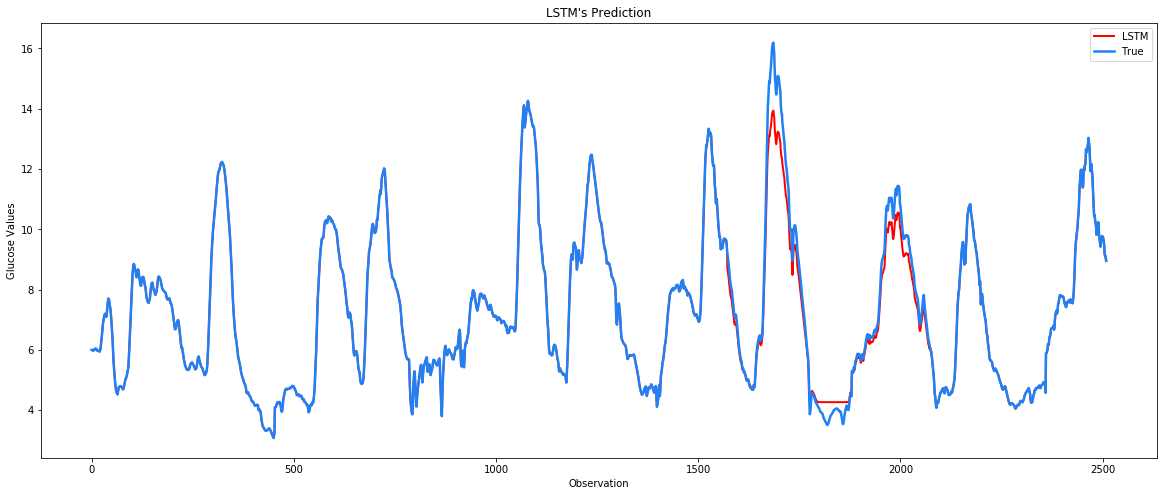

Index of Agreement is: 0.986
Mean Absolute Error is: 0.4713160862570512
Root Mean Squared Error is: 0.679
Mean Absolute Difference is: [2.9849608]
Fractional Bias is: 0.057
Mean Absolute Percentage Error is: 6.0


In [7]:
predicted, true = testModel(lstmModel,gap_tester_diabetic_1)

for i in range(0,501):
     diabetic_1_faulty['glucoseValue'][start+i] = predicted[i][0]

plot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist())
getMetrics(predicted,true)

In [8]:
#diabetic_1_faulty, diabetic_2_faulty, prediabetic_faulty, non_diabetic_faulty = testingData()
start, end = createGap(diabetic_2)
gap_tester_diabetic_2 = diabetic_2.iloc[start:end+2]
diabetic_2_faulty = faultyData(diabetic_2_faulty,start,end+1)

501/501 [==============================] - 0s 810us/step
LSTM: 0.004875


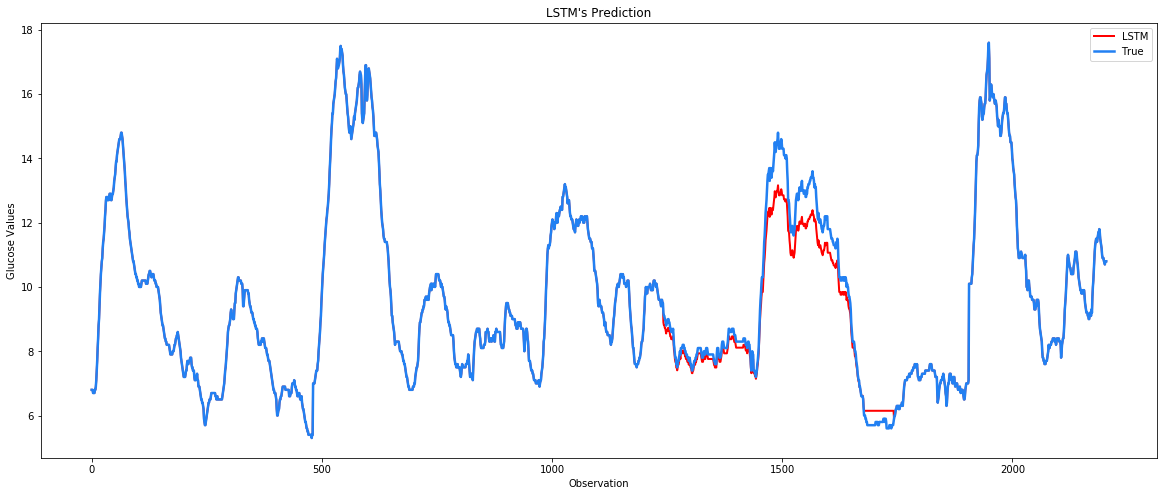

Index of Agreement is: 0.982
Mean Absolute Error is: 0.48536596755067746
Root Mean Squared Error is: 0.642
Mean Absolute Difference is: [2.346985]
Fractional Bias is: 0.048
Mean Absolute Percentage Error is: 5.0


In [9]:
predicted, true = testModel(lstmModel,gap_tester_diabetic_2)

for i in range(0,501):
    diabetic_2_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist())
getMetrics(predicted,true)

In [10]:
start, end = createGap(prediabetic)
gap_tester_prediabetic = prediabetic.iloc[start:end+2]
prediabetic_faulty = faultyData(prediabetic_faulty,start,end+1)

501/501 [==============================] - 0s 882us/step
LSTM: 0.001926


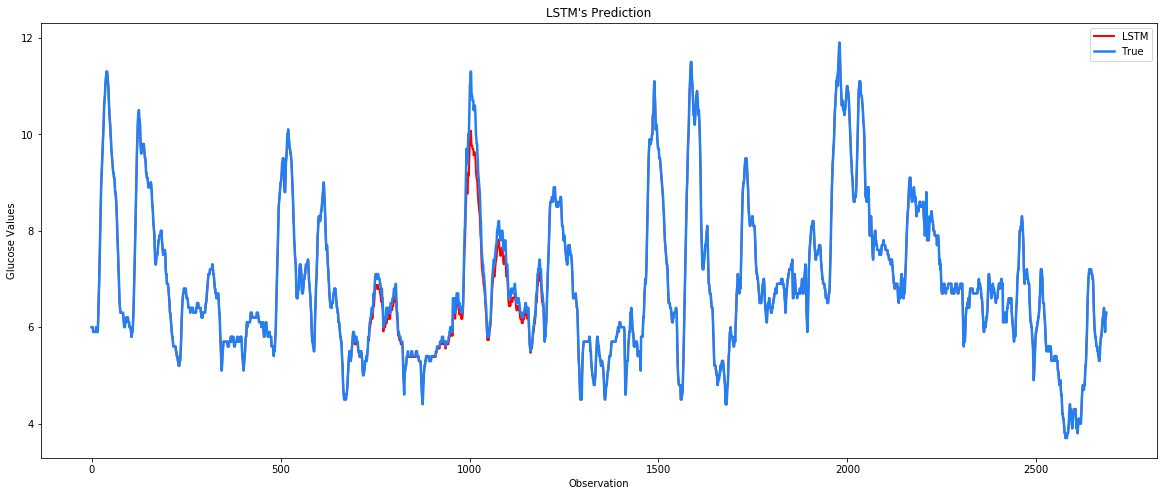

Index of Agreement is: 0.984
Mean Absolute Error is: 0.19658313492339052
Root Mean Squared Error is: 0.303
Mean Absolute Difference is: [0.9112409]
Fractional Bias is: 0.027
Mean Absolute Percentage Error is: 3.0


In [11]:
predicted, true = testModel(lstmModel,gap_tester_prediabetic)

for i in range(0,501):
    prediabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist())
getMetrics(predicted,true)

In [12]:
start, end = createGap(non_diabetic)
gap_tester_non_diabetic = non_diabetic.iloc[start:end+2]
non_diabetic_faulty = faultyData(non_diabetic_faulty,start,end+1)

501/501 [==============================] - 0s 900us/step
LSTM: 0.004355


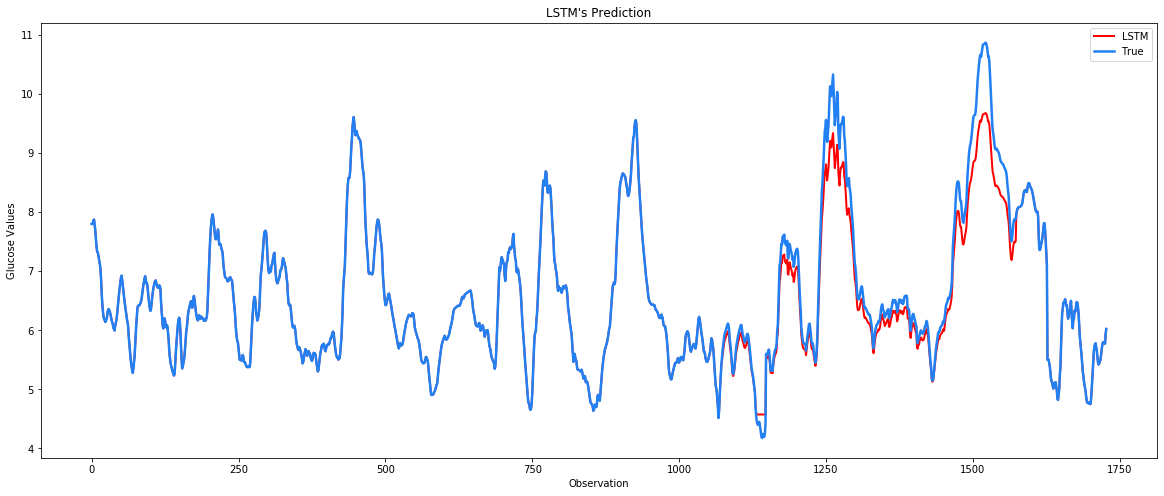

Index of Agreement is: 0.977
Mean Absolute Error is: 0.3294390064551683
Root Mean Squared Error is: 0.442
Mean Absolute Difference is: [1.0827639]
Fractional Bias is: 0.043
Mean Absolute Percentage Error is: 4.0


In [13]:
predicted, true = testModel(lstmModel,gap_tester_non_diabetic)

for i in range(0,501):
    non_diabetic_faulty['glucoseValue'][start+i] = predicted[i][0]
    
plot(non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())
getMetrics(predicted,true)

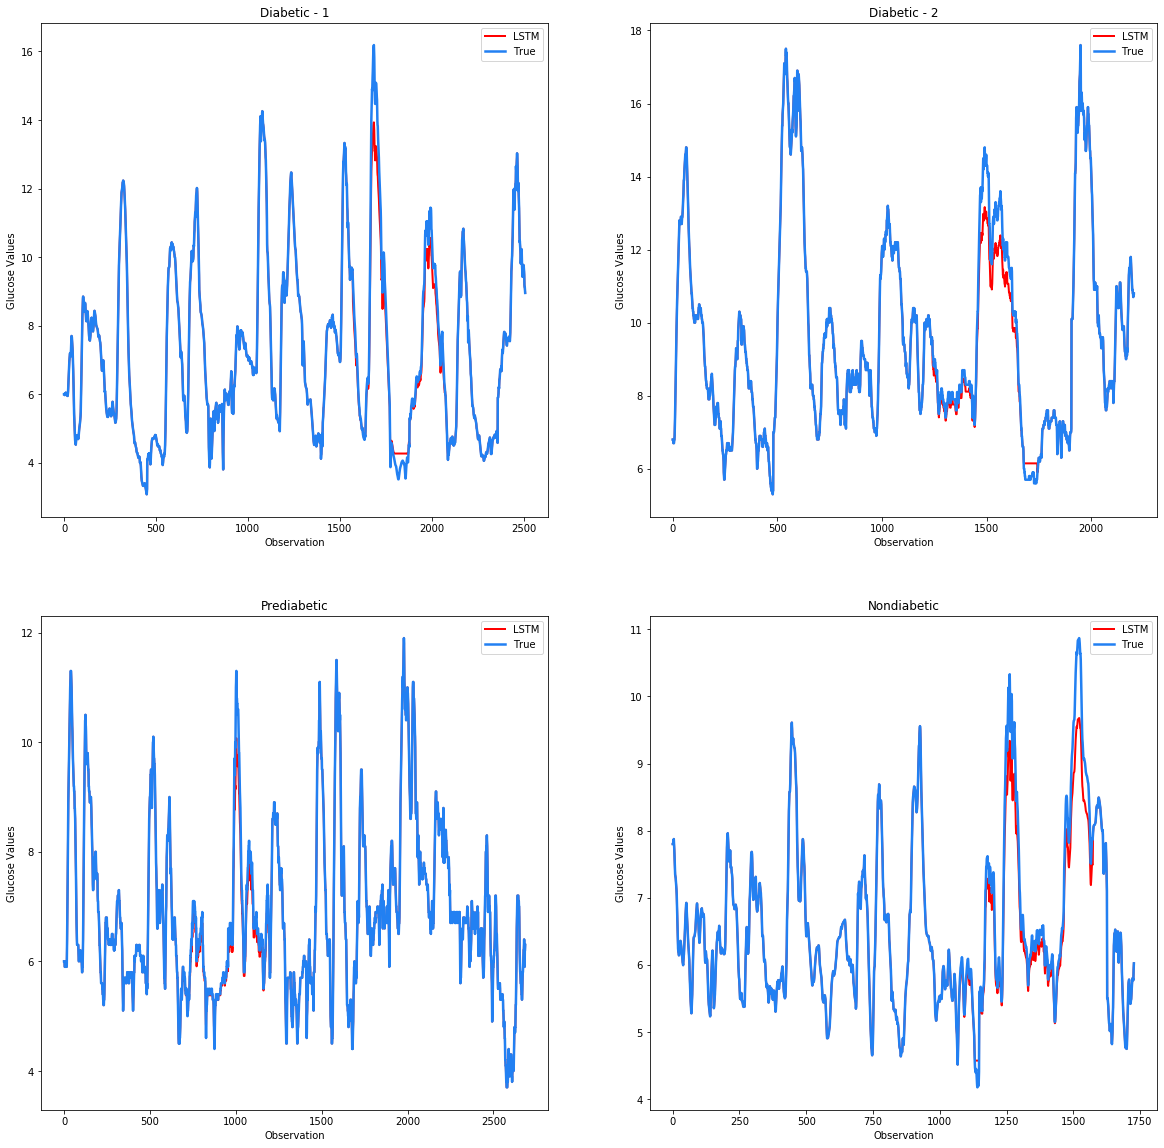

In [14]:
summaryPlot(diabetic_1_faulty['glucoseValue'].tolist(),diabetic_1['glucoseValue'].tolist(),diabetic_2_faulty['glucoseValue'].tolist(),diabetic_2['glucoseValue'].tolist(),prediabetic_faulty['glucoseValue'].tolist(),prediabetic['glucoseValue'].tolist(),non_diabetic_faulty['glucoseValue'].tolist(),non_diabetic['glucoseValue'].tolist())